In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

# Fault Condition 4 is all about the "operating states of the AHU." 

* Or in English refers to how often is the AHU program is jumping into a heating, cooling, economizer, back to heating, then economizing, then mechanical cooling.... DDC programs that are not tuned, believe it or not they can do that! As highlighted below the AHU schematic picture we can try and tell the operating states of the AHU by looking at the economizing damper positions as well as the heating and cooling signals or valve positions all in percent %.

Schematic below is from this blog about HVAC: https://www.hvacbrain.com/blog/vav-versus-vvt/

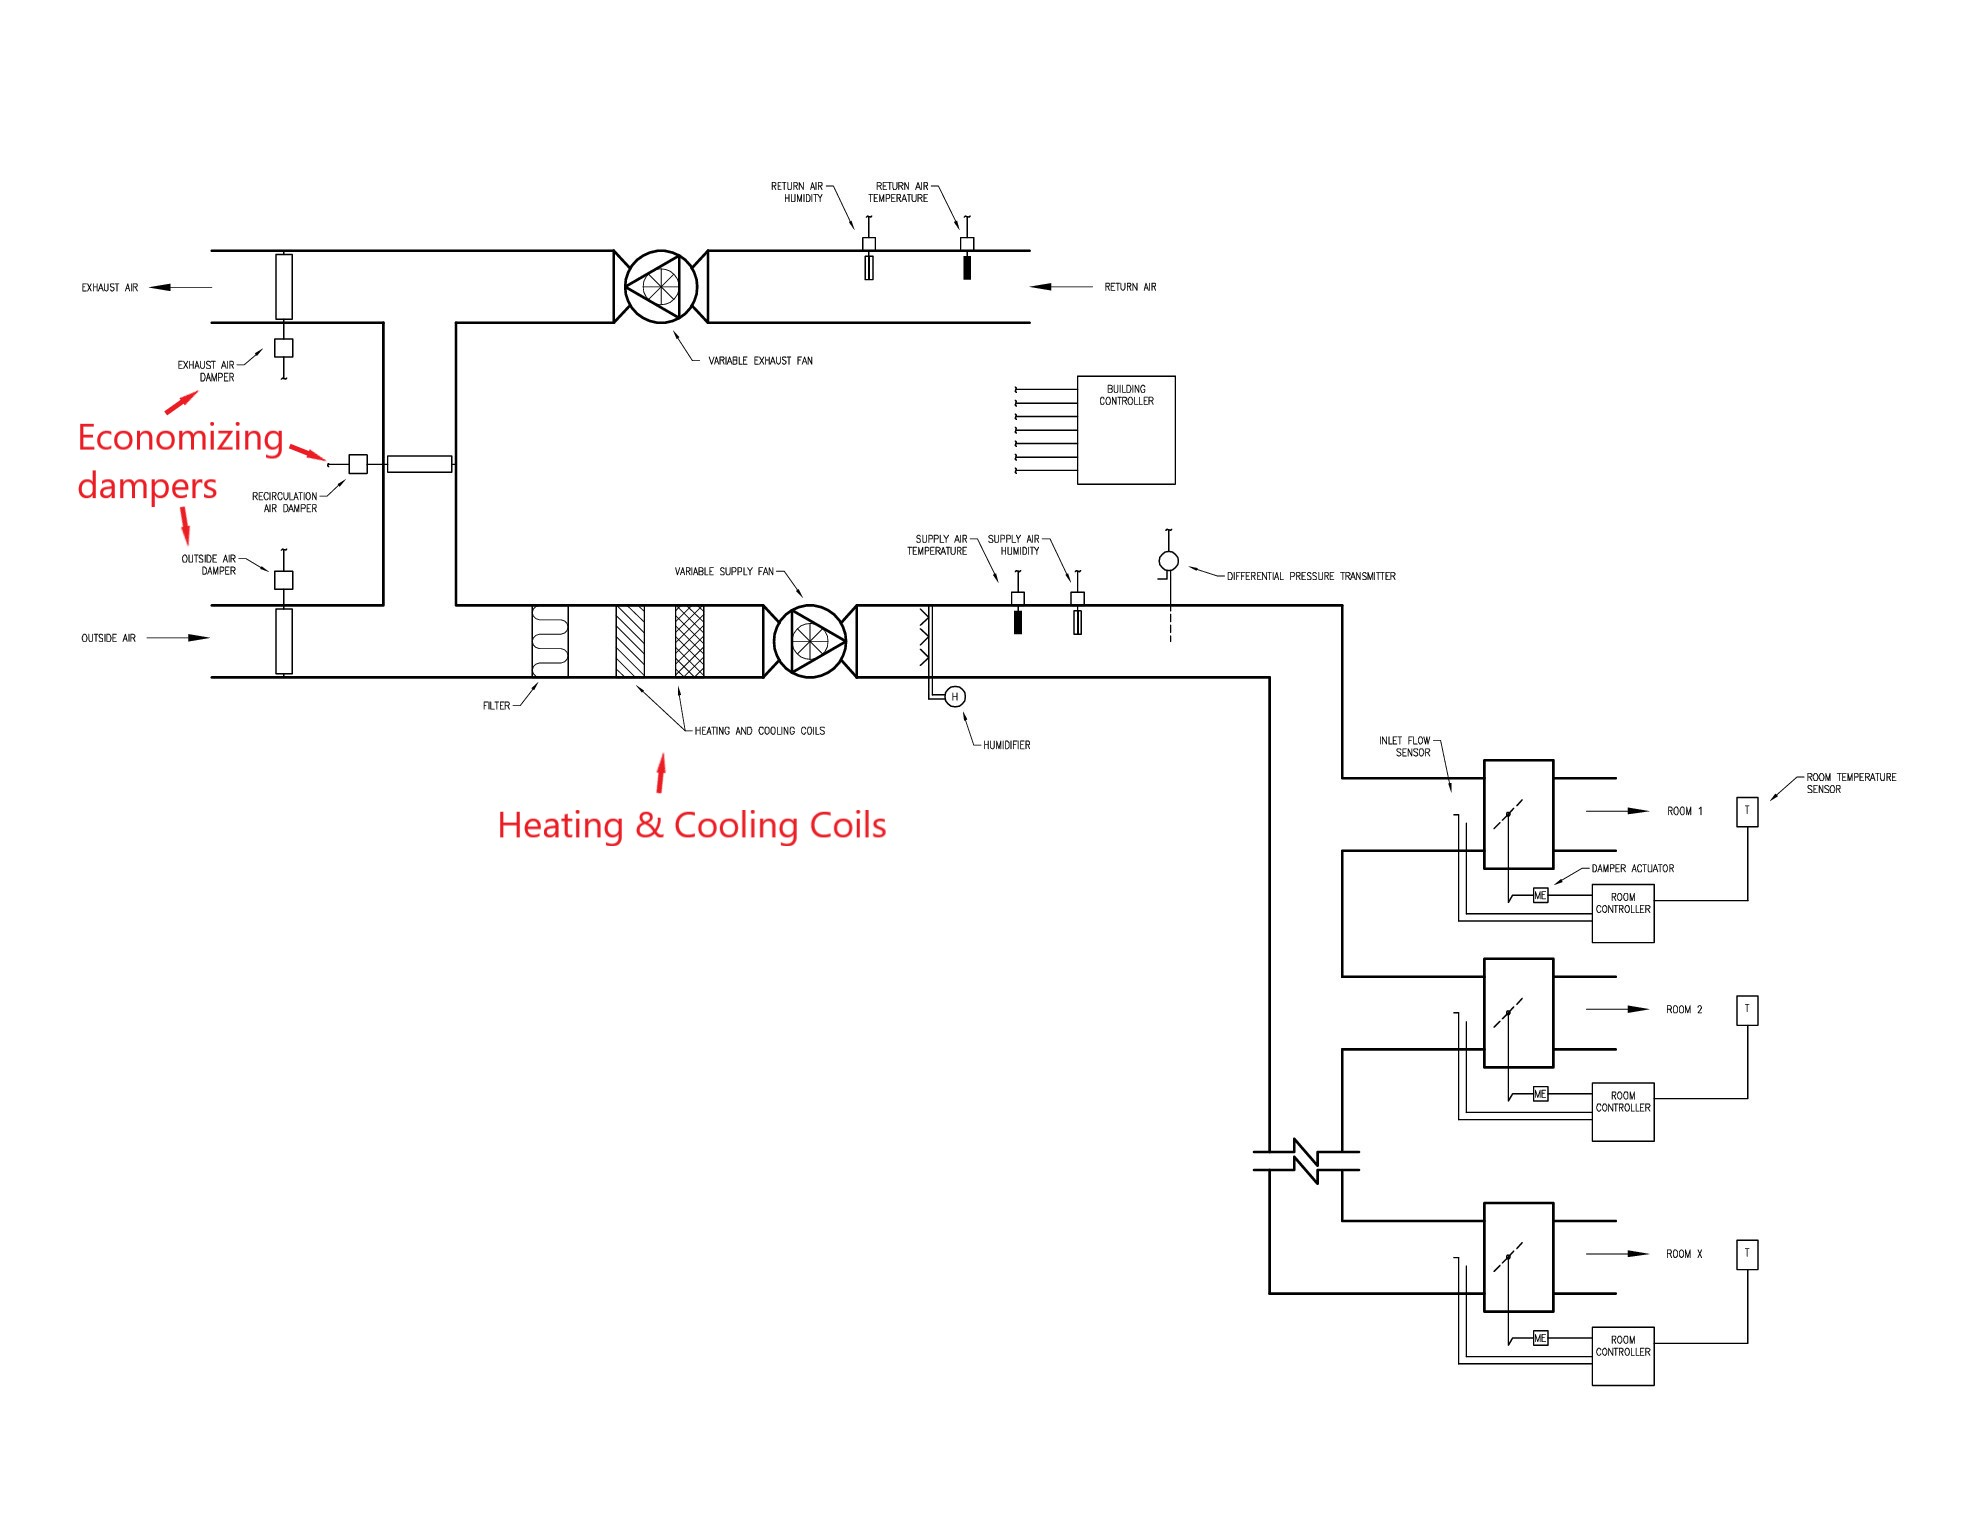

# Like FC 1,2,3, FC4 measure applies to all conditions for the AHU

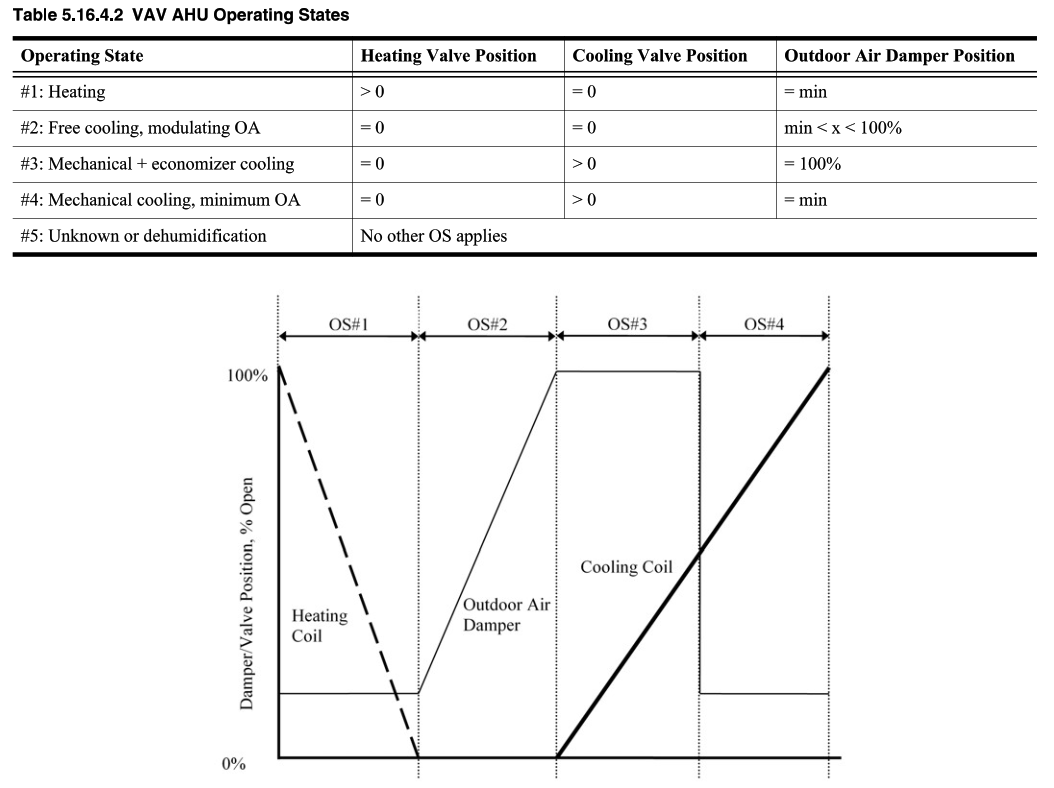

* This image above denotes a heating mode, economizer mode, economizer + mechanical cooling, and mechanical cooling only moving left to right based on the data coming from the heating valve, outside air damper, and cooling.

# Snip of ASHRAE Fault Condition 4

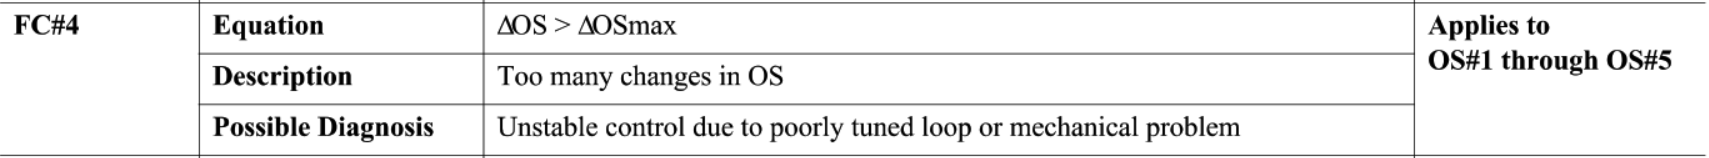

* Note that this equation cannot directly be translated into code but I think the image above can be useful for defining "OS" operating states based on heating valve signal, cooling valve signal, and the outside air damper signal.

In [2]:
def fault_condition_four(dataframe):
    return (dataframe.mat + dataframe.mix_degf_err_thres < np.minimum((dataframe.rat - dataframe.return_degf_err_thres) , (dataframe.oat - dataframe.outdoor_degf_err_thres)))

# Read Associated CSV files forward fill dataset and remove NaNs

In [3]:
rtu_os_states = pd.read_csv('./shoulder_season_data/RTU Data-fc4-2021-11-15 07_10_01.csv', index_col='Time', parse_dates=True).fillna(method='ffill').dropna()

* Note rolling average not computed for this measure


In [4]:
rtu_os_states.columns

Index(['slipstream_internal/slipstream_hq/1100/Cooling Capacity Status',
       'slipstream_internal/slipstream_hq/1100/Heating Capacity Primary Status',
       'slipstream_internal/slipstream_hq/1100/Outdoor Air Damper Command'],
      dtype='object')

In [5]:
# rename columns
rtu_os_states.rename(columns={'slipstream_internal/slipstream_hq/1100/Cooling Capacity Status': 'cooling_sig', # discharge air temp not needed
                   'slipstream_internal/slipstream_hq/1100/Heating Capacity Primary Status': 'heating_sig',
                   'slipstream_internal/slipstream_hq/1100/Outdoor Air Damper Command': 'economizer_sig'}, inplace=True)

In [6]:
rtu_os_states.columns

Index(['cooling_sig', 'heating_sig', 'economizer_sig'], dtype='object')

In [7]:
# small dataset logged from VOLTTRON on 1 min intervals.
# In economizer season November


rtu_os_states.describe()

,cooling_sig,heating_sig,economizer_sig
count,10080.000000,10080.000000,10080.000000
mean,0.195846,2.506149,19.834088
std,1.218951,13.113482,29.467393
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000
75%,0.000000,0.000000,52.300000
max,10.700000,100.000000,100.000000


# Plot data for visulation 

array([<AxesSubplot:xlabel='Time'>, <AxesSubplot:xlabel='Time'>,
       <AxesSubplot:xlabel='Time'>], dtype=object)

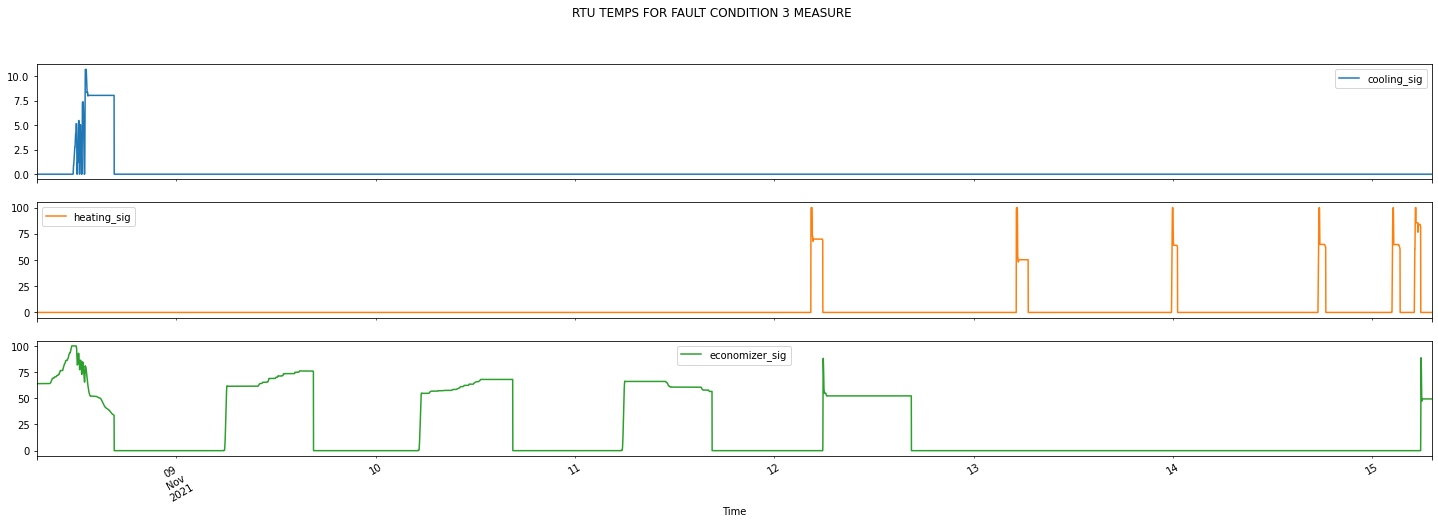

In [8]:
rtu_os_states_copy = rtu_os_states.copy()

rtu_os_states.plot(figsize=(25,8), subplots=True, title='RTU TEMPS FOR FAULT CONDITION 3 MEASURE')

* Note just by looking at this chart its easy to see that there is not a lot of different "modes" happening. Some mechanical cooling + economizer cooling on the left and as we look towards the right the AHU transitions into just economizing, and then finally just heating. Its also worth noting economizer + mechanical cooling is OK based on if conditions outside are suitable for "free cooling" but economizing and heating is NEVER okay. Economizing and heating is like driving down the highway in a car with running both the gas and brake pedal at the same time.

# Set Internal Variables per G36 Spec Imperial Units

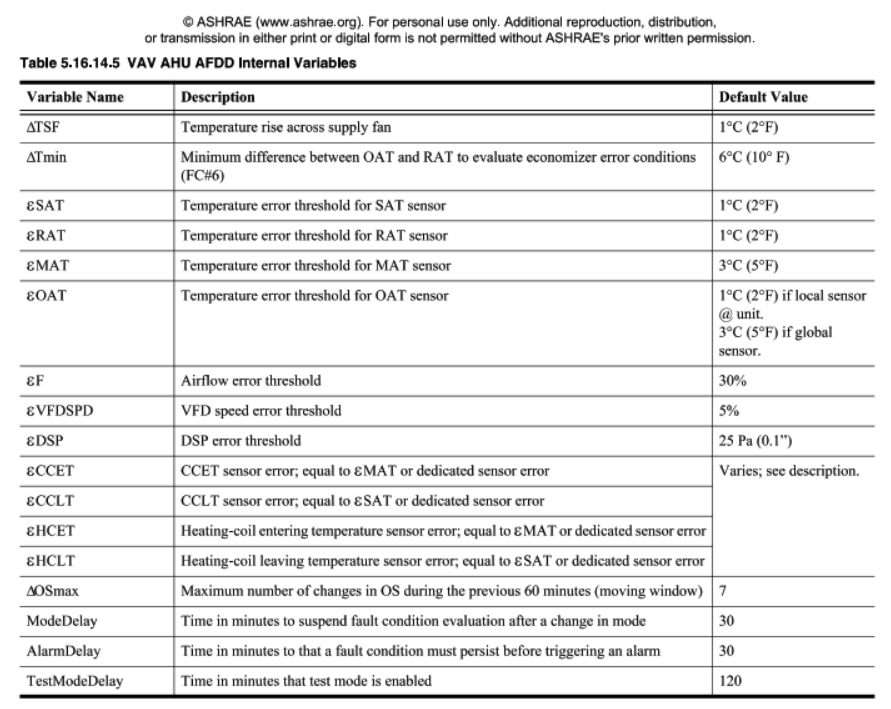

In [9]:
supply_fan_delta_degf = 2.
oat_rat_delta_degf_min = 10.
supply_degf_err_thres = 2.
return_degf_err_thres = 2.
mix_degf_err_thres = 5.
outdoor_degf_err_thres = 5. 
air_flow_percent_thres = .3
vfd_speed_percent_err_thres = .05
vfd_speed_percent_max = .99
duct_static_inches_err_thres = .1
delta_os_max = 7. # <----- THIS PARAM on FC4 for max state changes for DDC going in and out of different "Modes"
mode_delay = 30.
alarm_dely = 30.
test_mode_delay = 120.

# Param from BAS for AHU min OA setpoint determined by balancing contractor

In [10]:
ahu_min_oa = 20

In [11]:
# make an entire column out of these params in the Pandas Dataframe
rtu_os_states['delta_os_max'] = delta_os_max
rtu_os_states['ahu_min_oa'] = ahu_min_oa

In [12]:
rtu_os_states.columns

Index(['cooling_sig', 'heating_sig', 'economizer_sig', 'delta_os_max',
       'ahu_min_oa'],
      dtype='object')

# LETS look again at the OS states:

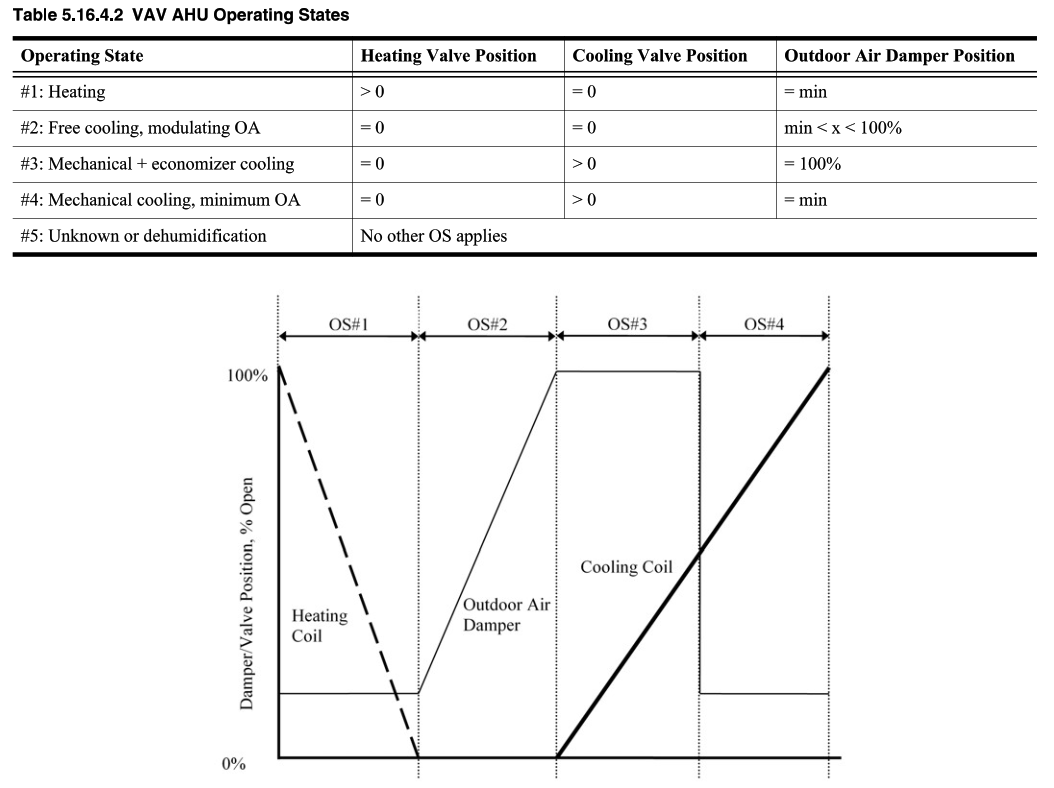

* Logic in next cell below is Boolean True False. For each row in the dataset through Pandas we can determine the "MODE" based on the % heating signal, cooling signal, and ecomizing dampers.

In [13]:
rtu_os_states['heating_mode'] = rtu_os_states['heating_sig'].gt(0.)
rtu_os_states['econ_mode'] = rtu_os_states['economizer_sig'].gt(rtu_os_states['ahu_min_oa']) & rtu_os_states['cooling_sig'].eq(0.)
rtu_os_states['econ+mech_cooling_mode'] = rtu_os_states['economizer_sig'].gt(rtu_os_states['ahu_min_oa']) & rtu_os_states['cooling_sig'].gt(0.)
rtu_os_states['mech_cooling_mode'] = rtu_os_states['economizer_sig'].eq(rtu_os_states['ahu_min_oa']) & rtu_os_states['cooling_sig'].gt(0.)

In [14]:
rtu_os_states = rtu_os_states[['heating_mode','econ_mode','econ+mech_cooling_mode','mech_cooling_mode']]

In [15]:
rtu_os_states = rtu_os_states.astype(int)

* Cell below using the lambda function is attempting to look at how many changes per hour in "MODES. First the data is resampled per hour in Pandas and the lambda function will totalize the sum of events in that hour for 'heating_mode','econ_mode','econ+mech_cooling_mode','mech_cooling_mode.' What the lambda function is also incorporating is for each row of data (1 minute) if the last row was the same "MODE" dont count it as a new event. For example on one minute intervals in consecutive order if half of the data was cooling_mode and half of the data heating_mode, only count 2 mode changes that hour.

https://stackoverflow.com/questions/69979832/pandas-consecutive-boolean-event-rollup-time-series

In [16]:
rtu_os_states = rtu_os_states.resample('H').apply(lambda x: (x.eq(1) & x.shift().ne(1)).sum())

In [17]:
# Create a debug dataframe for later
rtu_os_states_debug =  rtu_os_states.copy()

In [18]:
rtu_os_states.columns

Index(['heating_mode', 'econ_mode', 'econ+mech_cooling_mode',
       'mech_cooling_mode'],
      dtype='object')

In [19]:
# delta_os_max is what we defined Internal Variables per G36 Spec Imperial Units
# value of 7, so I think if there are more than 7 changes per hour == FLAG!!!

rtu_os_states['fc4_flag'] = rtu_os_states[rtu_os_states.columns].gt(delta_os_max).any(1)

rtu_os_states = rtu_os_states.astype(int)

rtu_os_states

,heating_mode,econ_mode,econ+mech_cooling_mode,mech_cooling_mode,fc4_flag
Time,,,,,
2021-11-08 07:00:00,0,1,0,0,0
2021-11-08 08:00:00,0,1,0,0,0
2021-11-08 09:00:00,0,1,0,0,0
2021-11-08 10:00:00,0,1,0,0,0
2021-11-08 11:00:00,0,1,1,0,0
...,...,...,...,...,...
2021-11-15 03:00:00,1,0,0,0,0
2021-11-15 04:00:00,0,0,0,0,0
2021-11-15 05:00:00,1,1,0,0,0


<AxesSubplot:xlabel='Time', ylabel='Mode Counts'>

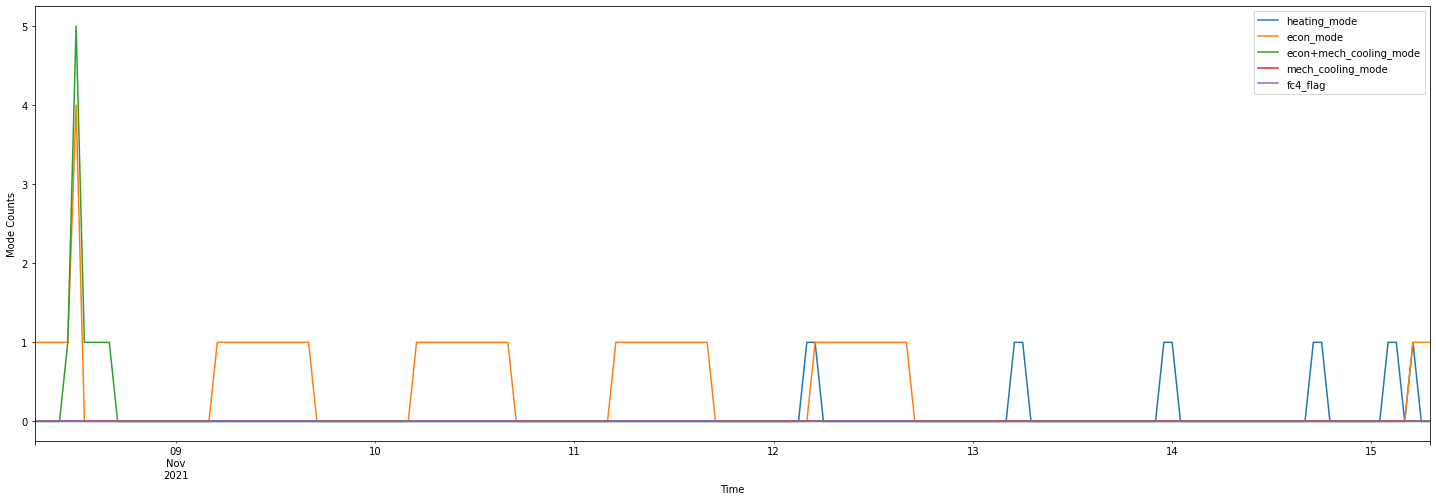

In [20]:
rtu_os_states.plot(figsize=(25,8),ylabel='Mode Counts')

# First day seems interesting...? So how many counts can you see on this first day? 


* I see 4 econ_modes and 5 economizer+mechanical_cooling_mode

* So according to the equation we are not supposed to jump into more than 7 modes in one hour as we defined earlier with param delta_os_max = 7.

In [21]:
# delta_os_max = 7. # <----- THIS PARAM on FC4 for max state changes for DDC going in and out of different "Modes"

* Zooming on that 1st day on the line chart

<AxesSubplot:xlabel='Time', ylabel='Mode Counts'>

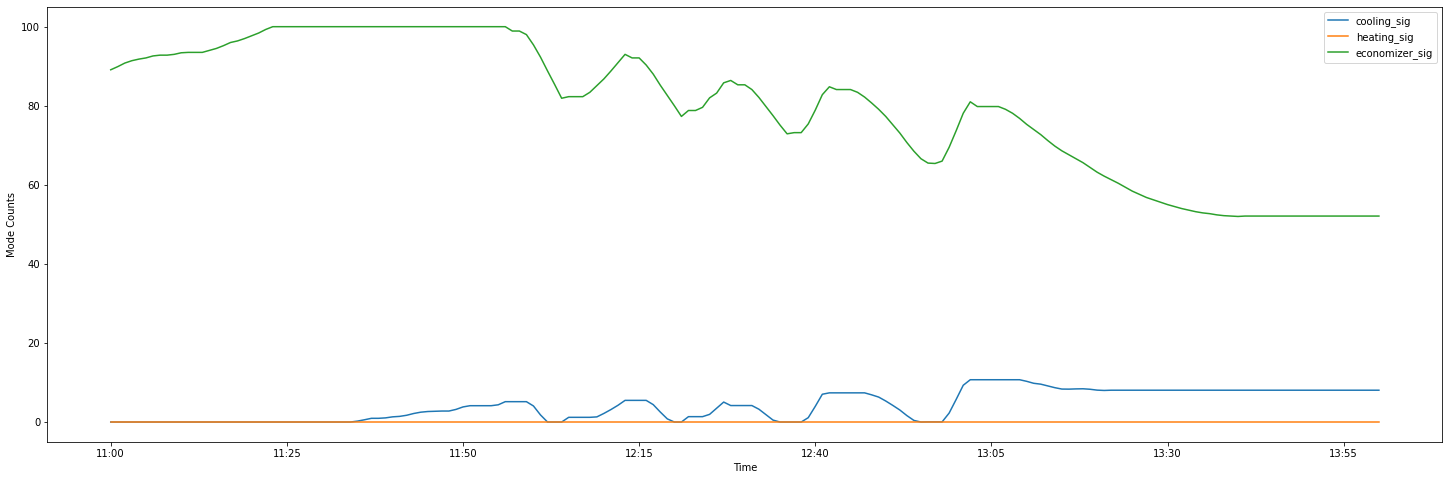

In [22]:
zoom_date = '2021-11-8'
fdd_plot_zoom1 = rtu_os_states_copy.loc[zoom_date].between_time('11:00','14:00')

# code here is to make the zoom plot x axis readable with units of time
fdd_plot_zoom1.index = fdd_plot_zoom1.index.map(lambda x: x.strftime("%H:%M"))

fdd_plot_zoom1.plot(figsize=(25,8),ylabel='Mode Counts')

# INTERESTING! Lets mark it up!

* The waves in the lines are a little bit of hunting of the system or short cycling, I can easily see 4 counts. I think everytime the cooling coil goes to zero percent the AHU programming is jumping from mechanical_cooling to economizer+plus_mechanical_cooling. It seems like the economizer open 100% was not enough cooling to meet demand but the bringing on mechanical cooling on low load conditions was just enough to make the system short cycle or hunt a little bit.

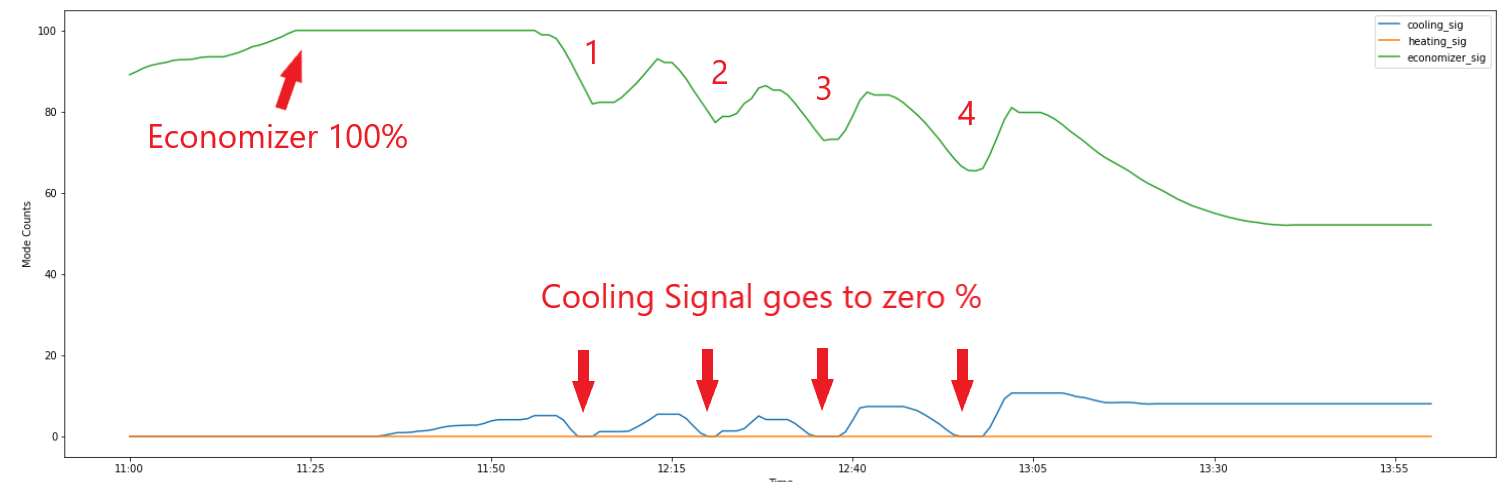

# If you could glance at the building automation controller driving the AHU

* It may look like this below, the screen shots are from the JCI software called CCT for an air handling unit program. These relatively simple GUI based PLC type programs to drive HVAC equipment, inputs are on the LEFT and outputs are on the RIGHT. Ladder logic blocks are in the middle deciding the "MODES" for the equipment to be in...


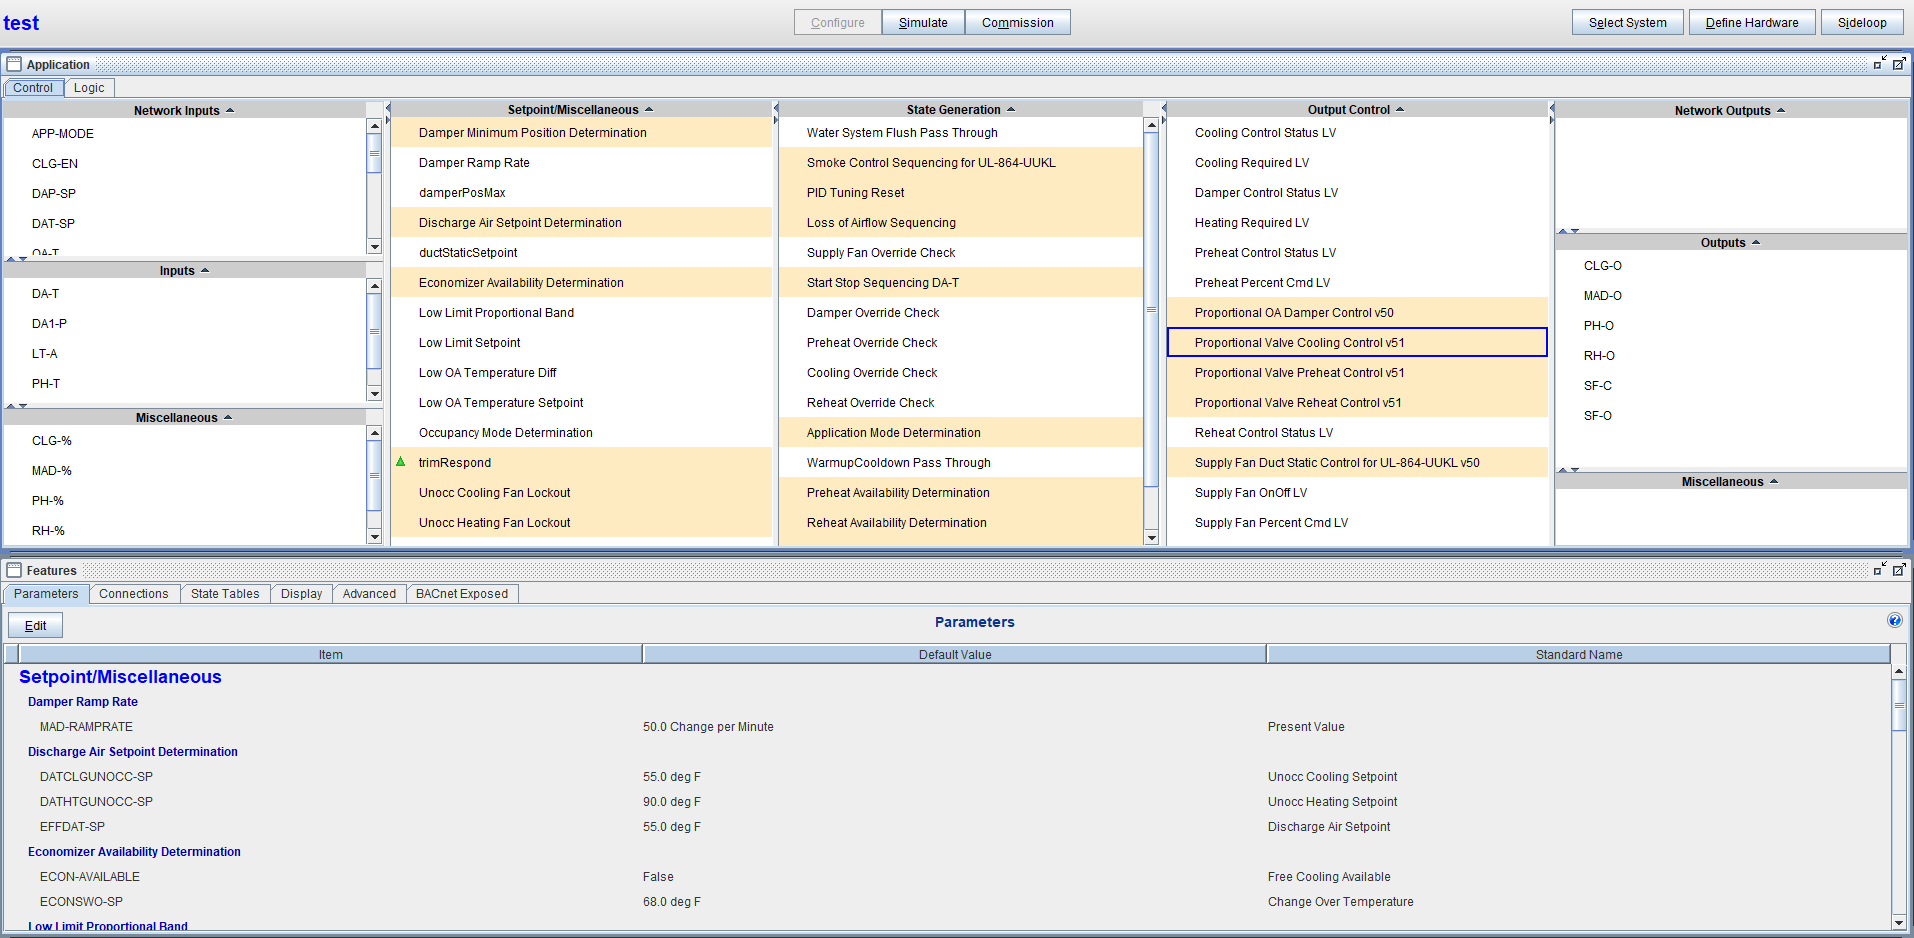

* Diving deeper into a ladder logic block highlighted in GREEN below with a box, the BAS program will jump between "MODES" like ECON or ECON+mech, and depending this state that determines whether the cooling valve should Off or in control which is defined as T Control. Thats why when we see in the data that the cooling valve went to zero % (this could be anything even a heating valve or air damper position in %) that there is a likely hood that the "MODE" changed in the BAS programming. Ultimetely too many "MODE" changes due to un-tuned BAS programs or mechanical issues causing excess mode changes can cause excess equipment wear and tear, comfort complaints, and excess energy waste.

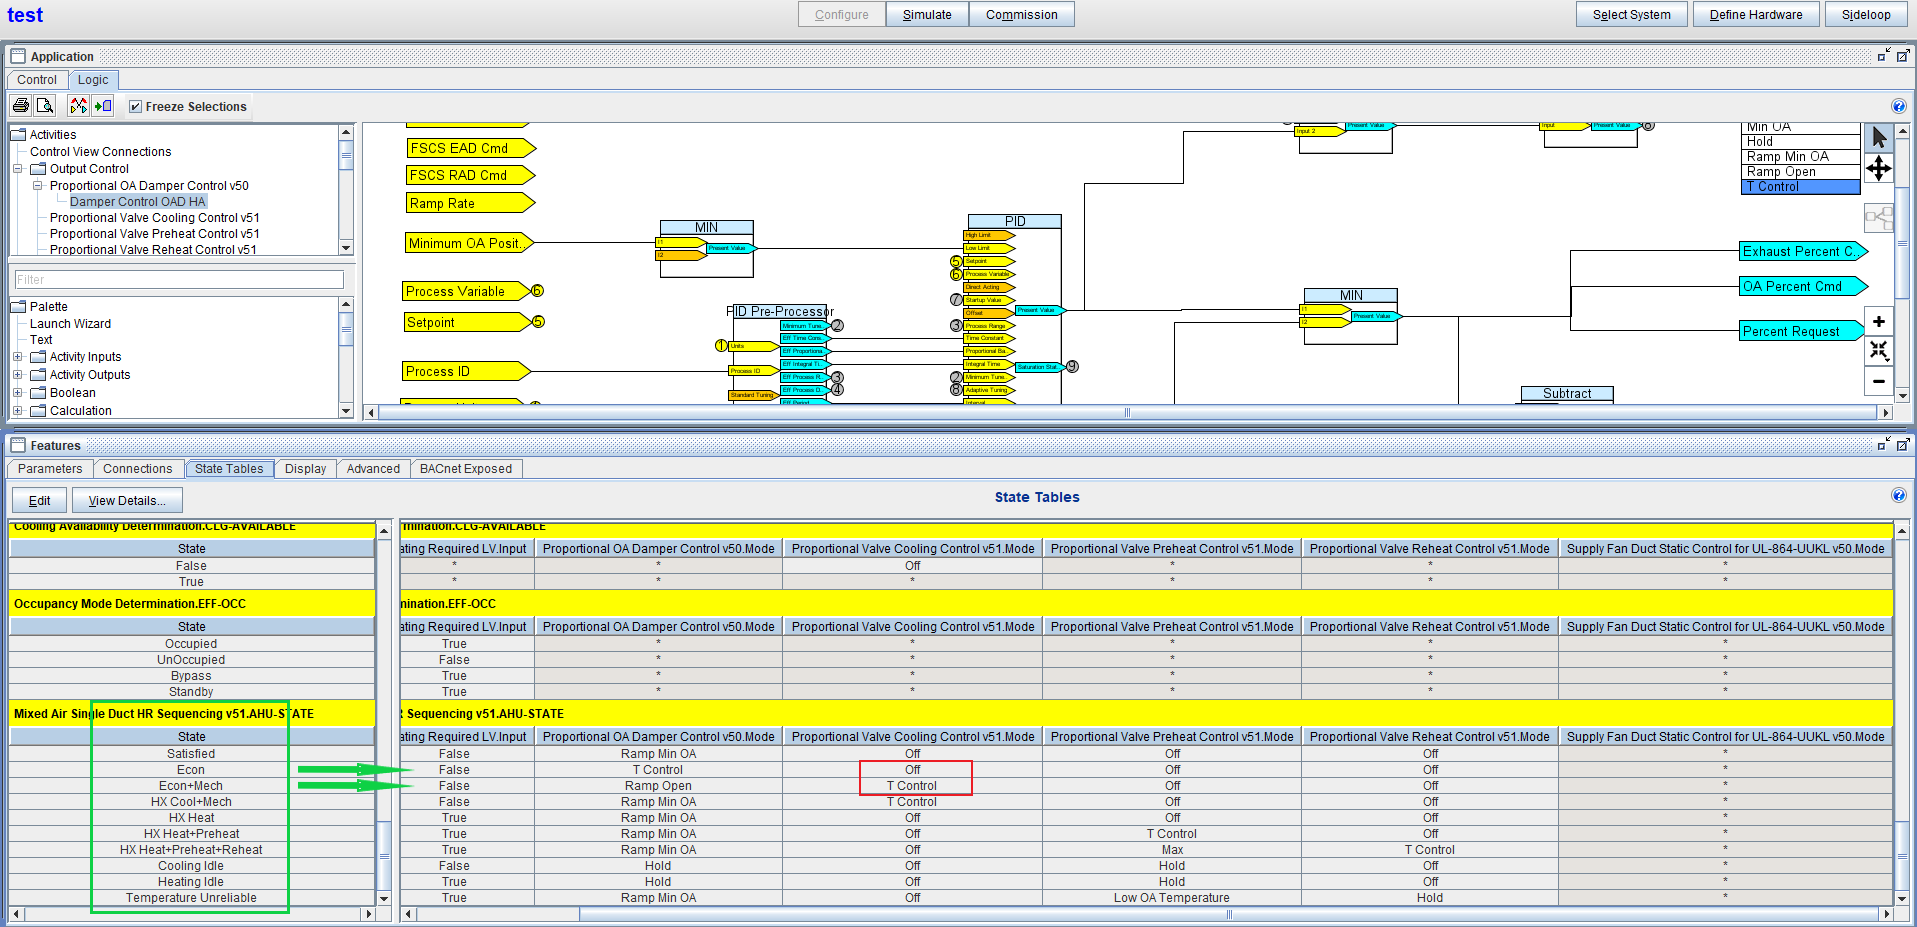

In [23]:
# Total count of fc4 flag

rtu_os_states.fc4_flag.value_counts()

0    169
Name: fc4_flag, dtype: int64

# The second D in FDD is "Diagnostics"

No diagnostics on this one as there appears to be no FLAGS!

* Calculate percent TRUE AND FALSE of FDD Flag

In [24]:
percent_true = rtu_os_states.fc4_flag.mean()

print("Percent of time in the dataset when FLAG is True")

percent_true

Percent of time in the dataset when FLAG is True


0.0

In [25]:
percent_false = 1 - percent_true

print("Percent of time in the dataset when FLAG is False")

percent_false

Percent of time in the dataset when FLAG is False


1.0

* Calculate elapsed time for fault conditions True

In [26]:
fc4_dataset_copy = rtu_os_states.copy()


#filter dataset for when "FLAG" is True
fc4_dataset_copy = fc4_dataset_copy[fc4_dataset_copy.fc4_flag == 1]


In [27]:
fc4_dataset_copy.fc4_flag.sum()

0

In [28]:
fc4_dataset_copy['time_td'] = fc4_dataset_copy.index.to_series().diff().astype('timedelta64[m]')

In [29]:
print("TIME IN MINUTES the FLAG is TRUE")

fc4_dataset_copy.time_td.sum()

TIME IN MINUTES the FLAG is TRUE


0.0

In [30]:
print("TIME IN HOURS the FLAG is TRUE")

fc4_dataset_copy.time_td.sum() / 60

TIME IN HOURS the FLAG is TRUE


0.0

* Plot on histogram the hour of the day the "FLAG" is TRUE

<AxesSubplot:title={'center':'Hour Of Day When Flag is TRUE'}, ylabel='Frequency'>

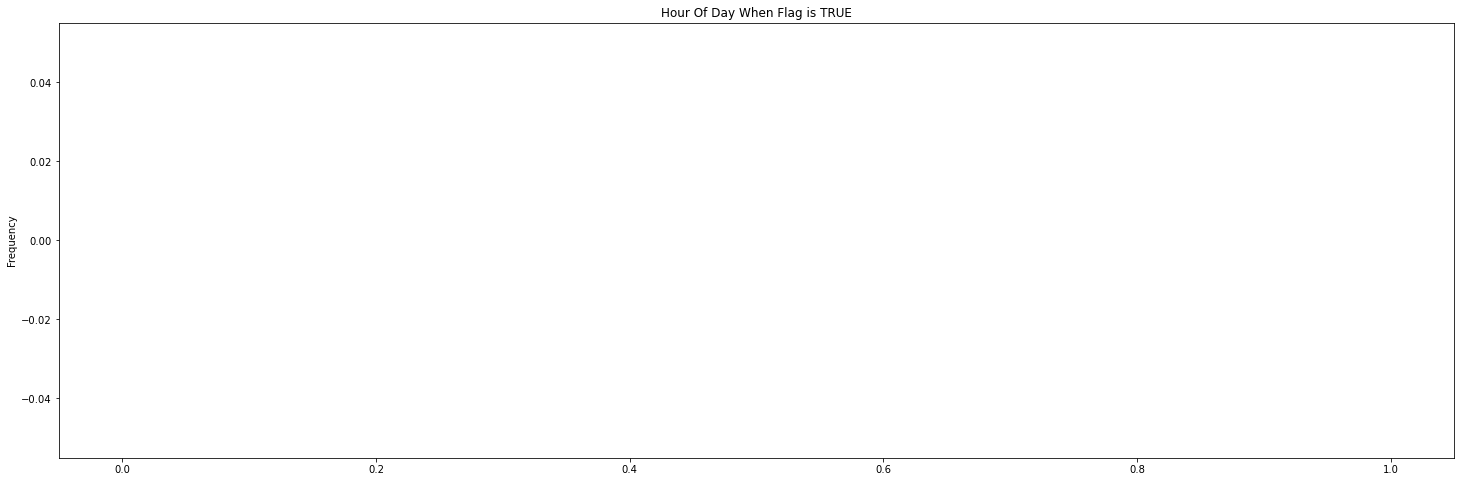

In [31]:
fc4_dataset_copy['hour_of_the_day'] = fc4_dataset_copy.index.hour

fc4_dataset_copy.hour_of_the_day.plot.hist(title='Hour Of Day When Flag is TRUE',figsize=(25,8))

In [32]:
# Outside air temp data not provided but would be interesting to see this if there were lots of faults.
# Per out temp if there were a range of lots of faults that would be a good clue there the programming
# is hunting or even a mechanical issue cauing lots of faults for when the equipment goes in and out of modes.

#print("Outside Air Temp Average for dataset when FLAG IS TRUE")

#fc4_dataset_copy.oat.mean()